# Twitter Sentiment Classification Predict

© Explore Data Science Academy

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section you are required to import, and briefly discuss, the libraries that will be used throughout your analysis and modelling. |

---

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install worldcloud

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement worldcloud (from versions: none)
ERROR: No matching distribution found for worldcloud


In [3]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd
import numpy as np
import math
from scipy.sparse import csr_matrix
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk.downloader
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from sklearn.utils import resample

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.svm             import SVC
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, accuracy_score, log_loss, f1_score
from sklearn.feature_extraction.text import CountVectorizer

import pickle
import json
%matplotlib inline
pd.pandas.set_option('display.max_columns',None)

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section you are required to load the data from the `df_train` file into a DataFrame. |

---

In [4]:
# load the data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test_with_no_labels.csv')
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [5]:
df_test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, you are required to perform an in-depth analysis of all the variables in the DataFrame. |

---


In the exploratory data analysis, the following questions will be answered to get insights from the dataset:

What kind of data is this? (number of columns present & datatypes present in the dataset)

Are there any missing values?

Are there any duplicated values

Is there any relationship between different independent variables of the dataset? If yes then how strong is that relationship?


In [6]:
df_train.isnull()
#True = value is null

,sentiment,message,tweetid
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
15814,False,False,False
15815,False,False,False
15816,False,False,False
15817,False,False,False


# Target Variable Analysis

For the target variable analysis, the main focus will be on the distribution. The goal is to find out how the sentiment is distributed in our dataset, e.g., which sentiment has the highest value count, etc.

Thus the following will be explored:

summary statistics

sentiment data sample count

distribution of sentiment

In [7]:
#checking unique target values
df_train['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

In [8]:
#Summary statistics

df_train[['sentiment']].describe().T

,count,mean,std,min,25%,50%,75%,max
sentiment,15819.0,0.917504,0.836537,-1.0,1.0,1.0,1.0,2.0


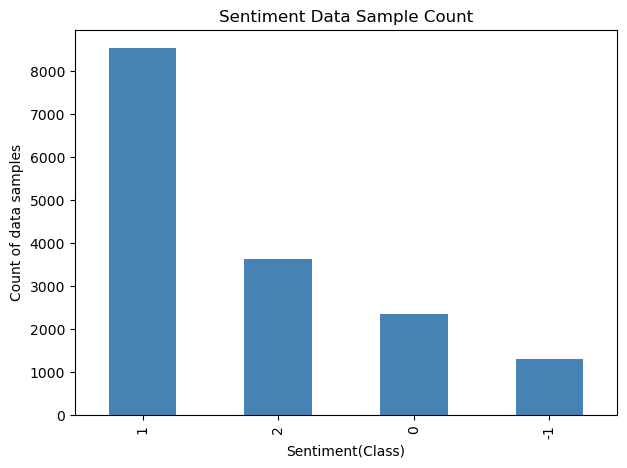

In [9]:
# Plotting sentiment data sample count

plt.figure(figsize=(7,5))
df_train['sentiment'].value_counts().plot(kind = 'bar', title='Sentiment Data Sample Count', color='steelblue')
plt.xlabel('Sentiment(Class)')
plt.ylabel("Count of data samples")
plt.show()


<AxesSubplot:title={'center':'Distribution of sentiment'}, ylabel='sentiment'>

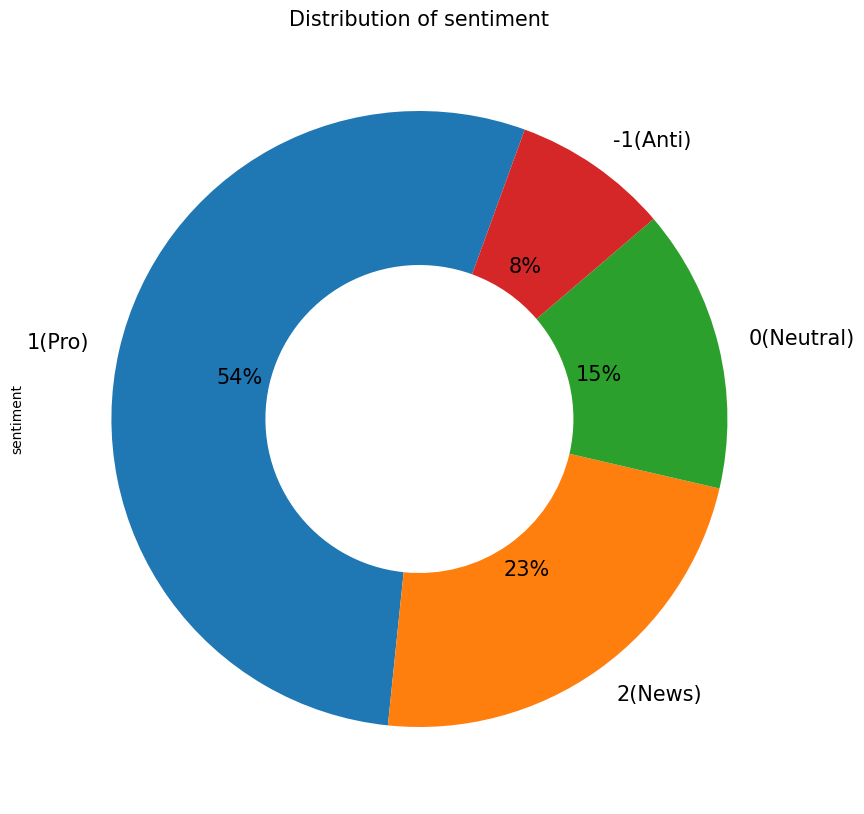

In [10]:
#plotting donut chart to see sentiment distribution

plt.figure(figsize=(10,10))
plt.title('Distribution of sentiment', fontsize=15)
plt.savefig("sentimentdonutchart.png")
df_train.sentiment.value_counts().plot(kind='pie', labels=['1(Pro)', '2(News)', '0(Neutral)', '-1(Anti)'],
                              wedgeprops=dict(width=.5), autopct='%1.0f%%', startangle= 70, 
                              textprops={'fontsize': 15})

As seen above on the donut chart, majority of the tweets in the dataset indicate users who are believe in man-made climate change while the minority of the tweets are anti man-made climate change.

For the data preprocessing, two hypotheses can be tested and explored to aid with the data modelling:

1.Believers of man-made climate change tweet more about taking actions to fight the phenomenon and so one might find more words relating to positive action to be present in the tweets

2.Climate change deniers use the term global warming much often than believers and use aggressive language and words such as "fake", etc.

# Tweet Analysis

According to the Twitter Help Center:

"A Retweet is a re-posting of a Tweet. Twitter's Retweet feature helps you and others quickly share that Tweet with all of your followers."

Following the hypotheses stated in the target variable analysis, one can add on the following regarding retweets (RT):

People who are pro the belief of man-made climate change, are more likely to retweet more than others. Their retweets can consist of factual news, web-urls, or even other believers' views.

To explore that hypothesis, below will be an analysis of the number of retweeted posted per sentiment.

In [11]:
# Splitting the dataset according to sentiment

pro = df_train[df_train['sentiment'] == 1]
anti = df_train[df_train['sentiment'] == -1]
neutral = df_train[df_train['sentiment'] == 0]
news = df_train[df_train['sentiment'] == 2]

In [12]:
# pro rt search 

substring = 'RT'
pro_rt = pro[pro.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
anti_rt = anti[anti.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
neutral_rt = neutral[neutral.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
news_rt = news[news.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]

In [13]:
#combining the retweet data frames into one subdataframe

RT_data = pd.concat([pro_rt, anti_rt, neutral_rt, news_rt])
RT_data.shape

(10628, 3)

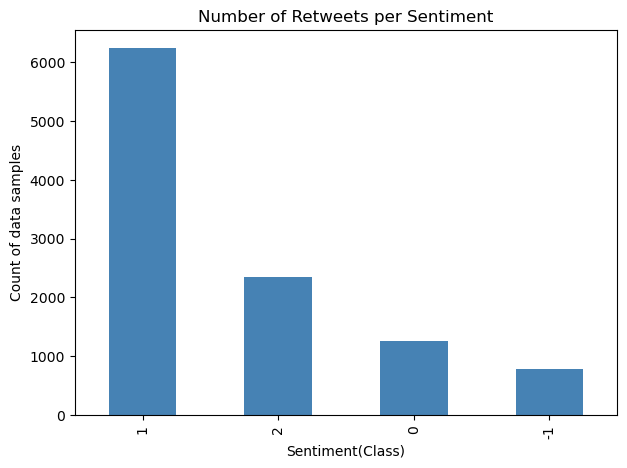

In [14]:
# Plotting sentiment data sample count

plt.figure(figsize=(7,5))
RT_data['sentiment'].value_counts().plot(kind = 'bar', title='Number of Retweets per Sentiment', color='steelblue')
plt.xlabel('Sentiment(Class)')
plt.ylabel("Count of data samples")
plt.show()

As suspected, sentiment class 1(Pro) has the highest number of retweets compared to all the other classes.

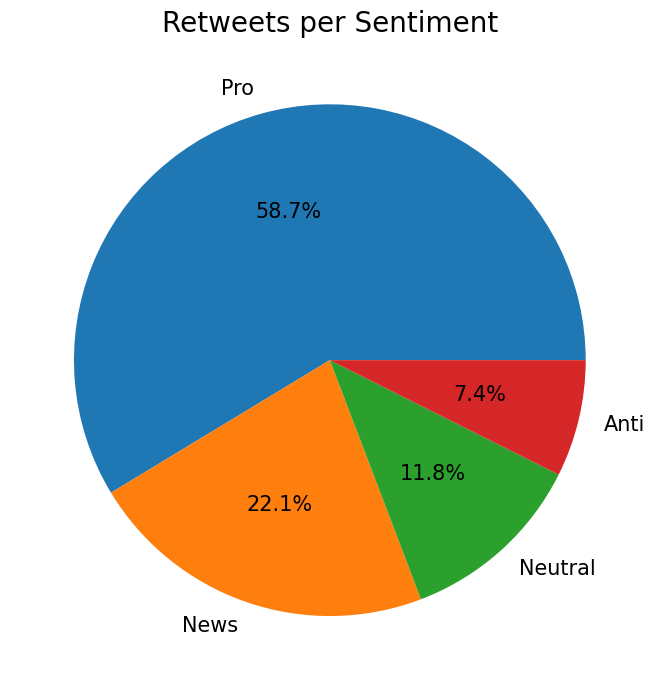

In [15]:
#Plotting pie chart to see distribution of retweets per sentiment

plt.figure(figsize = (7, 7))
plt.pie(RT_data.sentiment.value_counts().values, labels=['Pro', 'News', 'Neutral', 'Anti'], 
        autopct = '%2.1f%%', textprops={'fontsize': 15})
plt.title('Retweets per Sentiment', fontsize=20)
plt.tight_layout()
plt.show()

This analysis has proven the retweet hypothesis to be true and has shared insight on what steps to consider or what steps to leave out during the data cleaning stage.

# Data Preprocessing

A copy of the dataset will be made as a safety precaution.

In [16]:
df = df_train.copy()
dft = df_test.copy()

# Text Cleaning

In context of text analytics, removing noise is a vital part of getting the data into a usable format. For the train dataset, the following will be done:

removing '@'-mentions

removing the web-urls

making everything lower case

removing punctuation

removing digits and words containing digits

removing hashtags, emojis, and unknown characters

Once that is complete, the data will be ready for further analysis and text feature engineering.

# Removing @ mentions

In [17]:
# Removing mentions

def remove_mentions(input_text, pattern):
    '''
    This function serves to remove any mentions denoted by 
    the @ symbol, followed by the twitter handle.
    '''
    r_find = re.findall(pattern, input_text)
    for word in r_find:
        input_text = re.sub(word, '',input_text)
    return input_text

In [18]:
df['message'] = np.vectorize(remove_mentions)(df['message'],'@[\w]*')
df[['message']].head()

,message
0,PolySciMajor EPA chief doesn't think carbon di...
1,It's not like we lack evidence of anthropogeni...
2,RT : Researchers say we have three years to ac...
3,#TodayinMaker# WIRED : 2016 was a pivotal year...
4,"RT : It's 2016, and a racist, sexist, climate ..."


# Removing web-urls

In [19]:
#removing web-urls

pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r''
df['message'] = df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [20]:
#removing remaining https

pattern_url = r'https?:\/\/.*\/\w*'
subs_url = r''
df['message'] = df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

# Tweet Cleaner Function

In [21]:
def tweet_cleaner(tweet):
    
    """
    This function is necessary to remove punctuation, hashtags, 
    numbers and any extra white space from tweets after converting 
    everything to lowercase letters.
    
    """
    # Convert everything to lowercase
    tweet = tweet.lower() 
    
    # Remove punctuation
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', tweet)
    
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)    
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)  
    
    # Remove whitespace in front of tweet
    tweet = tweet.lstrip(' ')   
    
    # Remove extra whitespace
    tweet = re.sub(r'\s\s+', ' ', tweet)
                          
    
    return tweet

In [22]:
df['message'] = df['message'].apply(tweet_cleaner)
df.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn t think carbon di...,625221
1,1,it s not like we lack evidence of anthropogeni...,126103
2,2,rt researchers say we have three years to act ...,698562
3,1,todayinmaker wired was a pivotal year in the w...,573736
4,1,rt it s and a racist sexist climate change den...,466954


# Replacing "rt" with "retweet"

In [23]:
pattern_url = r'rt\s'
subs_url = r'retweet '
df['message'] = df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)
df.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn t think carbon di...,625221
1,1,it s not like we lack evidence of anthropogeni...,126103
2,2,retweet researchers say we have three years to...,698562
3,1,todayinmaker wired was a pivotal year in the w...,573736
4,1,retweet it s and a racist sexist climate chang...,466954


# Removing emojis

In [24]:
def remove_emojis(string):
    
    """"
    This function serves to remove emojis from the 
    tweets in the data.
    
    """
    
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', string)

In [25]:
df['message'] = df['message'].apply(remove_emojis)

# Removing unknown characters 

In [26]:
#removing the uknown charecters from words

pattern_url = r'[^A-Za-z ]'
subs_url = r''
df['message'] = df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

# Stopwords removal

Stopwords are the most common words in any natural language. For the purpose of analyzing text data and building NLP models, these stopwords might not add much value to the meaning of the document.

Generally, the most common words used in a text are “the”, “is”, “in”, “for”, “where”, “when”, “to”, “at” etc.

For this classification task, removing stopwords will help so that more focus can be given to those words which define the meaning of the text. Some stop words give context to the meaning of the word that follows. In this case, instead of removing all words, a list of stopwords wished to be removed will be defined and to be used in a function to remove stopwords.

In [27]:
#Defining the list of stopword wished to be removed. 

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'but', 'by', 'can', 'd', 'did',
             'does', 'doesn', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'shan', "shan't", 'she', "shes", 'should', 'shouldve','so', 'some', 'such',
             't', 'than', 'that', 'thatll', 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'wa', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'with', 'won', 'y', 'you', 'youd','youll', 'youre',
             'you', 've', 'your', 'yours', 'yourself', 'yourselves']

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [28]:
df['message'] = df['message'].apply(lambda text: cleaning_stopwords(text))
df[['message']].head()

,message
0,polyscimajor epa chief think carbon dioxide ma...
1,not like lack evidence anthropogenic global wa...
2,retweet researchers say three years act climat...
3,todayinmaker wired pivotal year war climate ch...
4,retweet racist sexist climate change denying b...


<a id="four"></a>
## 4. Feature Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section you are required to: clean the dataset, and possibly create new features - as identified in the EDA phase. |

---

# Tokenisation

Tokenization is a simple process that takes raw data and converts it into a useful data string. Tokenization is used in Natural Language Processing to split paragraphs and sentences into smaller units (i.e, tokens) that can be more easily assigned meaning.

In [29]:
#Creating tokenised column

tokeniser = TreebankWordTokenizer()
df['token'] = df['message'].apply(tokeniser.tokenize)

In [30]:
df.head()

,sentiment,message,tweetid,token
0,1,polyscimajor epa chief think carbon dioxide ma...,625221,"[polyscimajor, epa, chief, think, carbon, diox..."
1,1,not like lack evidence anthropogenic global wa...,126103,"[not, like, lack, evidence, anthropogenic, glo..."
2,2,retweet researchers say three years act climat...,698562,"[retweet, researchers, say, three, years, act,..."
3,1,todayinmaker wired pivotal year war climate ch...,573736,"[todayinmaker, wired, pivotal, year, war, clim..."
4,1,retweet racist sexist climate change denying b...,466954,"[retweet, racist, sexist, climate, change, den..."


# Lemmatization

Lemmatization is an organized & step-by-step procedure of obtaining the root form of the word. It makes use of vocabulary (dictionary importance of words) and morphological analysis (word structure and grammar relations).

To make the text in the dataset understandable for the machine, lemmatization needs to be performed.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
lemmatizer = WordNetLemmatizer()

def df_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]

In [33]:
df['lemma'] = df['token'].apply(df_lemma, args=(lemmatizer, ))

In [34]:
df.tail()

,sentiment,message,tweetid,token,lemma
15814,1,retweet took material global warming lgbt righ...,22001,"[retweet, took, material, global, warming, lgb...","[retweet, took, material, global, warming, lgb..."
15815,2,retweet climate change could breaking milliony...,17856,"[retweet, climate, change, could, breaking, mi...","[retweet, climate, change, could, breaking, mi..."
15816,0,notiven retweet nytimesworld trump actually be...,384248,"[notiven, retweet, nytimesworld, trump, actual...","[notiven, retweet, nytimesworld, trump, actual..."
15817,-1,retweet hey liberals climate change crap hoax ...,819732,"[retweet, hey, liberals, climate, change, crap...","[retweet, hey, liberal, climate, change, crap,..."
15818,0,retweet climate change equation screenshots,806319,"[retweet, climate, change, equation, screenshots]","[retweet, climate, change, equation, screenshots]"


A new column consisting of the lemmmatized words in string datatype will be created and used going forward in this report.

In [35]:
df['lemma_str'] = [' '.join(map(str,l)) for l in df['lemma']]
df.head()

,sentiment,message,tweetid,token,lemma,lemma_str
0,1,polyscimajor epa chief think carbon dioxide ma...,625221,"[polyscimajor, epa, chief, think, carbon, diox...","[polyscimajor, epa, chief, think, carbon, diox...",polyscimajor epa chief think carbon dioxide ma...
1,1,not like lack evidence anthropogenic global wa...,126103,"[not, like, lack, evidence, anthropogenic, glo...","[not, like, lack, evidence, anthropogenic, glo...",not like lack evidence anthropogenic global wa...
2,2,retweet researchers say three years act climat...,698562,"[retweet, researchers, say, three, years, act,...","[retweet, researcher, say, three, year, act, c...",retweet researcher say three year act climate ...
3,1,todayinmaker wired pivotal year war climate ch...,573736,"[todayinmaker, wired, pivotal, year, war, clim...","[todayinmaker, wired, pivotal, year, war, clim...",todayinmaker wired pivotal year war climate ch...
4,1,retweet racist sexist climate change denying b...,466954,"[retweet, racist, sexist, climate, change, den...","[retweet, racist, sexist, climate, change, den...",retweet racist sexist climate change denying b...


# Vectorization

NLTK's CountVectorizer can be used to clean text data and extract features, transforming the text data into a matrix of numbers that can be fed into a machine learning model.

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

The top 25 words that appear most often will be used, to make the model easier to train.

In [37]:
vect_25 = CountVectorizer(lowercase=True, max_features=25, analyzer='word', ngram_range=(1, 3))
X_count = vect_25.fit_transform(df['lemma_str'].values.astype(str))

In [38]:
# Let us see feature names
vect_25.get_feature_names()

C:\Users\Palesa Motsoahae\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['amp',
 'believe',
 'believe climate',
 'believe climate change',
 'change',
 'climate',
 'climate change',
 'do',
 'epa',
 'global',
 'global warming',
 'going',
 'http',
 'not',
 'people',
 'real',
 'retweet',
 'say',
 'scientist',
 'think',
 'trump',
 'via',
 'warming',
 'will',
 'world']

In [39]:
# Get shape of our new predictor variables
X_count.shape

(15819, 25)

In [40]:
X = X_count.toarray()

In [41]:
X = pd.DataFrame(X, columns= vect_25.get_feature_names())

In [42]:
X.head()

,amp,believe,believe climate,believe climate change,change,climate,climate change,do,epa,global,global warming,going,http,not,people,real,retweet,say,scientist,think,trump,via,warming,will,world
0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# Fit label encoder and return encoded labels
y = df[['sentiment']]

In [44]:
y

,sentiment
0,1
1,1
2,2
3,1
4,1
...,...
15814,1
15815,2
15816,0
15817,-1


# Class Imbalance

As seen in the exploratory, the dataset classes are imbalanced. Imbalance data can hamper the models' accuracy big. In order to tackle this issue, the dataset has to be resampled. In order to do this, resampling techniques will be used.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [46]:
# Separate sentiment into classes 
Neutral = df[df['sentiment']==0]
Pro = df[df['sentiment']==1]
Anti = df[df['sentiment']==-1]
News = df[df['sentiment']==2]

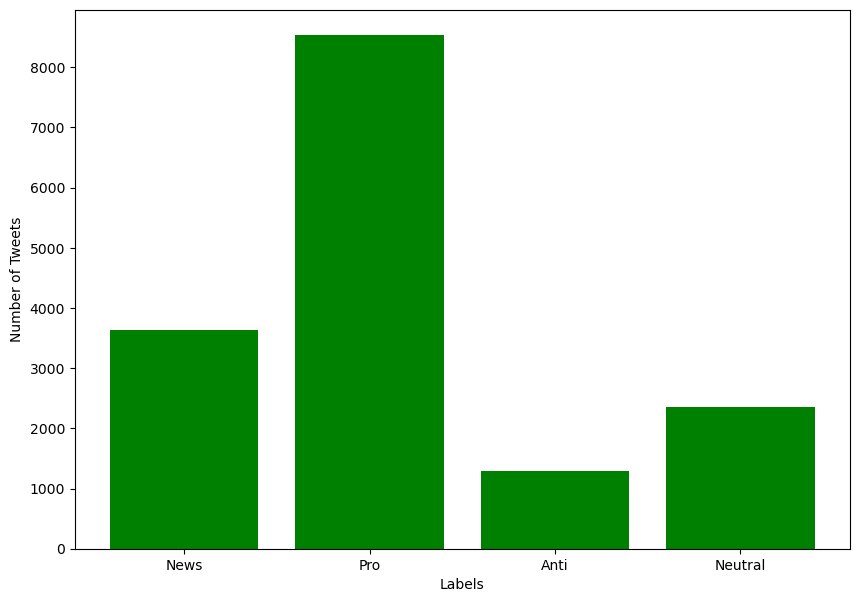

In [47]:
# Get all possible labels
labels = df['sentiment'].unique()
heights = [len(Anti),len(Neutral), len(Pro), len(News)]
plt.figure(figsize=(10,7))
plt.bar(labels,heights,color='green')
plt.xticks(labels,['Anti','Neutral','Pro','News'])
plt.xlabel('Labels')
plt.ylabel("Number of Tweets")
plt.savefig("Sentiment.png")
plt.show()

<a id="five"></a>
## 5. Training Models
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, you are required to create one or more regression models that are able to accurately predict the thee hour load shortfall. |

---

# Bernoulli Naive Bayes

Bernoulli Naive Bayes is a part of the Naive Bayes family. It is based on the Bernoulli Distribution and accepts only binary values, i.e., 0 or 1. If the features of the dataset are binary, then we can assume that Bernoulli Naive Bayes is the algorithm to be used.

In [48]:
from sklearn.metrics import classification_report, accuracy_score, log_loss

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [ ]:
# Compare model performance

In [ ]:
# Choose best model and motivate why it is the best choice

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model explanation ⚡ |
| :--------------------------- |
| In this section, you are required to discuss how the best performing model works in a simple way so that both technical and non-technical stakeholders can grasp the intuition behind the model's inner workings. |

---

In [ ]:
# discuss chosen methods logic